In [1]:
#imports
import numpy as np 
import sympy as sp
from sympy.utilities import lambdify
from sympy.solvers import solve
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
plt.style.use('seaborn')
import pandas as pd

In [18]:
class DoublePendulum:
    
    def __init__(self, t, m_1, m_2, l_1, l_2, g,the1_0, the2_0, v1_0, v2_0):
        
        self.t = t
        self.m1 = m_1
        self.m2 = m_2
        self.l1 = l_1
        self.l2 = l_1
        self.g = g
        
        self.conds = [the1_0, v1_0, the2_0, v2_0]
        
        
    
    def solve(self):
        
        #symbols
        
        m1,m2,l1,l2,t,g = sp.symbols(('m1','m2','l1','l2','t','g'))
        
        theta1, theta2 = sp.Function('theta1')(t), sp.Function('theta2')(t)
        
        dtheta1, dtheta2 = theta1.diff(t), theta2.diff(t)
        
        ddtheta1, ddtheta2 = dtheta1.diff(t), dtheta2.diff(t)
        
        x1,y1 = l1*sp.sin(theta1), -l1*sp.cos(theta1)
        x2,y2 = x1+ l2*sp.sin(theta2), y1-l2*sp.cos(theta2)
        
        #kinetic
        v1_sq = x1.diff(t)**2+y1.diff(t)**2
        v2_sq = x2.diff(t)**2+y2.diff(t)**2
        
        T = sp.Rational(1,2)*m1*v1_sq + sp.Rational(1,2)*m2*v2_sq
        
        #potential
        V = m1*g*y1+m2*g*y2
        
        #Lagrangian
        L=T-V
        
        
        
        #get the equations of motion
        
        def get_eq(theta, dtheta, L):
            
            rhs = L.diff(theta) 
            lhs = sp.diff(L.diff(dtheta),t)
            
            return rhs-lhs
    
        e1 = get_eq(theta1,dtheta1,L)
        e2 = get_eq(theta2,dtheta2,L)
        
        accels = sp.solve([e1,e2], (ddtheta1, ddtheta2))
        
        e1, e2 = accels[ddtheta1], accels[ddtheta2]
        
        #lambdify
        
        dthe1dt_num = sp.lambdify(dtheta1, dtheta1)
        dthe2dt_num = sp.lambdify(dtheta2, dtheta2)
        
        du1dt_num = sp.lambdify((m1,m2,l1,l2,g,theta1,theta2,dtheta1,dtheta2), e1)
        du2dt_num = sp.lambdify((m1,m2,l1,l2,g,theta1,theta2,dtheta1,dtheta2), e2)
        
        x1_num, y1_num = sp.lambdify((l1,theta1), x1), sp.lambdify((l1,theta1), y1)
        x2_num, y2_num = sp.lambdify((l1,l2,theta1,theta2), x2), sp.lambdify((l1,l2,theta1,theta2), y2)
        
        
        def dXdt(X,t):
            
            theta1_num, u1_num, theta2_num, u2_num = X
            
            return [dthe1dt_num(u1_num),
                    
                    du1dt_num(self.m1,self.m2, self.l1, self.l2, self.g, theta1_num, theta2_num, u1_num, u2_num),
                    
                    dthe2dt_num(u2_num),
                    
                    du2dt_num(self.m1,self.m2, self.l1, self.l2, self.g, theta1_num, theta2_num, u1_num, u2_num)]
        
        
        
        sols = odeint(dXdt, y0 = self.conds, t=self.t)
        
        angle1, angle2 = sols.T[0], sols.T[2]
        
        return x1_num(self.l1, angle1), y1_num(self.l1, angle1), x2_num(self.l1,self.l2, angle1, angle2), y2_num(self.l1,self.l2, angle1, angle2)
                    
                    
                    
                    
        
                          
        

In [19]:
t = np.linspace(0,40,2000)
DoublePend = DoublePendulum(t, 1,1,1,1,9.81,np.pi, 0, np.pi/4, 0)
x1, y1, x2,y2 = DoublePend.solve()

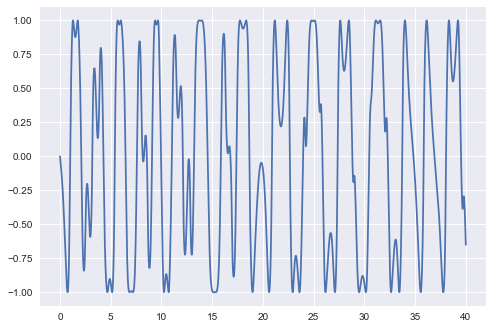